## Summary:

### text-processing(simple):
- all text tokenized to words
- spaces put around punctuation
- 'nt and 's reformed into tokens
- vocabulary size of 60k kept
- all other tokens recognised as 'unk'
- finally all texts padded to size 50

### Model architecture:        
- simple lstm model
- a single lstm layer with hidden dimension = 50, layer dimension = 2
- initialized with an embedding layer, with embedding size = 100
- a fully connected layer (mainly to flatten) of output dimension 10
- final fully connected layer of output dimension 1, for binary classification
- dropout of 0.5 used

### Why you used these models:
- lstm is the most generic kind of layer that applies best for sequence analysis, thats why lstm was used
- since the whole input will be given at once, bidirectional lstm was used to capture information from both sides of the input text

### Room for improvement:
- hyperparameters can be tuned well
- convolutional layers can be applied and analysed
- in case of cnn, character level cnn may be analysed

## Getting Data

In [0]:
# !pip install kaggle

In [0]:
!mkdir .kaggle

In [0]:
!mkdir ~/.kaggle

In [0]:
import json
token = {'username':'','key':''}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [13]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets list

In [0]:
!kaggle datasets list -s sentiment

In [20]:
!kaggle competitions download -c nlp-hack -p /content

  0% 0.00/99.0 [00:00<?, ?B/s]
100% 99.0/99.0 [00:00<00:00, 175kB/s]
 54% 9.00M/16.6M [00:00<00:00, 30.3MB/s]
100% 16.6M/16.6M [00:00<00:00, 47.6MB/s]
 79% 53.0M/66.9M [00:00<00:00, 42.0MB/s]
100% 66.9M/66.9M [00:00<00:00, 114MB/s] 


In [21]:
!unzip \*.zip

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  train.csv.zip
  inflating: train.csv               

2 archives were successfully processed.


## Starts here

In [0]:
import numpy as np
import pandas as pd
import os
files=['train.csv','test.csv','sample-submission.csv']

## Imports

In [0]:
import numpy as np
import pandas as pd
import os
import string
import re
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch.utils.data
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from collections import Counter
import pickle

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## See Data

In [26]:
train = pd.read_csv(files[0],index_col=0)
test = pd.read_csv(files[1],index_col=0)
train.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,date,user,text,target
Id,,,,
0,Fri Jun 05 22:04:23 PDT 2009,JGoldsborough,"@jbtaylor WIth ya. &quot;I'd like a Palm Pre, ...",4
1,Sat Jun 06 03:12:21 PDT 2009,Psioui,"felt the earthquake this afternoon, it seems t...",4
2,Sat May 30 19:02:49 PDT 2009,adriville,"Ruffles on shirts are like so in, me Likey",4
3,Thu Jun 25 05:59:18 PDT 2009,Blondie128,Pretty bad night into a crappy morning....FML!...,0
4,Sat May 30 11:16:35 PDT 2009,khrabrov,"@dcbriccetti yeah, what a clear view!",4


In [27]:
len(train)

1280000

In [0]:
# pd.set_option('display.max_colwidth',-1)
# train['text'][:10]

In [0]:
# text = [text for text in train['text']]
# text[:3]

## Test tokenization

In [0]:
# Str = """aysha   \tkamal

# also this is two new\x0b\x0clines"""
# "".join([replacements.get(c,c) for c in Str])

In [0]:
# import re

# hum = re.compile("([\'!\"#$%&()*+,-./:;<=>?@[\]^_`{|}~\\\])")

In [0]:
# Str = "\\\\\\\\\\\\"
# x = hum.sub(r' \1 ',Str);
# print(x)

In [0]:
# Str = "aysha aren't you the                 sweetest?+,-./:;text<=lol>?@[\kamal"
# x = hum.sub(r' \1 ',Str);
# print(x)

In [0]:
# re_apos = re.compile(r"n ' t ")    # n't
# re_bpos = re.compile(r" ' s ")     # 's
# re_mult_space = re.compile(r"  *") # replace multiple spaces with just one

# sent = re_apos.sub(r" n't ", x)
# sent = re_bpos.sub(r" 's ", sent)
# sent = re_mult_space.sub(' ', sent) ; sent

In [0]:
# print(sent)

In [0]:
# sent="AYSHA kamal Tanny TANny"
# ret = ['xbos']
# for w in sent.split():
#     if w.isupper():
#         ret.append('xwup')
#     elif w[0].isupper():
#         ret.append('xup')
#     ret.append(w.lower())
# ret

## Tokenization

In [0]:
### All tokenizations combined
re_punc = re.compile("([\'!\"#$%&()*+,-./:;<=>?@[\]^_`{|}~\\\])") # add spaces around punctuation
## () for capturing group, [] for one of the groups in the braces
re_apos = re.compile(r"n ' t ")    # n't
re_bpos = re.compile(r" ' s ")     # 's
re_mult_space = re.compile(r"  *") # replace multiple spaces with just one
replacements = {'\t':' ','\n':' ','\r':' ','\x0b':' ','\x0c':' '}

def simple_toks(sent):
    sent = "".join([replacements.get(c,c) for c in sent])
    sent = re_punc.sub(r" \1 ", sent) # \1 is the group that we have captured
    sent = re_apos.sub(r" n't ", sent)
    sent = re_bpos.sub(r" 's ", sent)
    sent = re_mult_space.sub(' ', sent)
    ret = ['xbos']
    for w in sent.split():
        if w.isupper():
            ret.append('xwup')
        elif w[0].isupper():
            ret.append('xup')
        ret.append(w.lower())
    return ret

In [0]:
textlist = train['text'].apply(simple_toks).tolist()

In [0]:
with open("tokenized.txt", "wb") as fp:   #Pickling
    pickle.dump(textlist, fp)

# with open("tokenized.txt", "rb") as fp:   # Unpickling
#     textlist = pickle.load(fp)

## Vocabulary Creation

In [0]:
from collections import Counter
full_vocab = Counter([w for row in textlist for w in row])

In [32]:
## 192 total characters
len(full_vocab)

575227

In [33]:
itos = ['xunk']+[word for word,cnt in full_vocab.most_common(60000)]
len(itos)

60001

In [34]:
stoi = {w:i for i,w in enumerate(itos)}
len(stoi)

60001

60k is MORE THAN ENOUGH I think

## Remove other words

In [0]:
# ## debug time
# original = textlist
# textlist = textlist[:10000]
# len(original), len(textlist)

In [0]:
# textlistfin=[[w if w in itos else itos[0] for w in sent] for sent in textlist]
# len(textlistfin), len(textlist)

 ## Numericalisation + remove unknown words

In [0]:
# ## testing
# textlist_test = train['text'][:10].apply(simple_toks).tolist()
# nums_test = [[stoi[w] if w in itos else 0 for w in sent] for sent in textlist_test]

In [35]:
nums = [[stoi[w] if w in itos else 0 for w in sent] for sent in textlist] ##so slow tho, NEED a way to parallel process
len(nums)

1280000

## labels

In [0]:
labels = train['target']/4

In [0]:
# ## debug time
# originalLabel = labels
# labels = labels[:10000]
# len(originalLabel), len(labels)

In [38]:
type(labels), labels.shape

(pandas.core.series.Series, (1280000,))

In [0]:
labels = np.array(labels).reshape(-1,1)

## Padding

In [0]:
max_length=50

In [0]:
padded = pad_sequences(nums, maxlen=max_length, padding='post', truncating='post', value=0)

In [42]:
padded.shape

(1280000, 50)

## Split

In [0]:
xtrain, xtest, ytrain, ytest = train_test_split(padded,labels,test_size = 0.1,random_state = 42)

## The model

In [0]:
xTrain = torch.from_numpy(xtrain).type(torch.LongTensor).to(device)
yTrain = torch.from_numpy(ytrain).type(torch.FloatTensor).to(device)

xTest = torch.from_numpy(xtest).type(torch.LongTensor).to(device)
yTest = torch.from_numpy(ytest).type(torch.FloatTensor).to(device)

In [45]:
xTrain.shape, yTrain.shape, xTest.shape, yTest.shape

(torch.Size([1152000, 50]),
 torch.Size([1152000, 1]),
 torch.Size([128000, 50]),
 torch.Size([128000, 1]))

In [46]:
xTrain.dtype, yTrain.dtype, xTest.dtype, yTest.dtype

(torch.int64, torch.float32, torch.int64, torch.float32)

In [47]:
xTrain.is_cuda

True

In [0]:
batch_size = 100
num_epochs = 20

# dataset
train = torch.utils.data.TensorDataset(xTrain,yTrain)
test = torch.utils.data.TensorDataset(xTest,yTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [0]:
class memodel(nn.Module):
    def __init__(self, vocabsz, mxlen):
        super().__init__()
        self.vocab_size=vocabsz
        self.mx_len=mxlen
        ##config
        self.embd_size=100
        self.hidden_dim=50
        self.hidden_dim2=10
        self.layer_dim=2
        self.output_dim=1
        self.drp=0.5
        ##layers
        self.embeddings = nn.Embedding(self.vocab_size, self.embd_size)
        ##when using pretained
#         self.embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
        self.lstm = nn.LSTM(input_size = self.embd_size,
                            hidden_size = self.hidden_dim,
                            num_layers = self.layer_dim,
                            dropout = self.drp, #keep
                            bidirectional = True)
        self.dropout = nn.Dropout(self.drp)
        self.fc = nn.Linear(2*self.hidden_dim*self.mx_len,self.hidden_dim2) #because bilinear
        self.out=nn.Linear(self.hidden_dim2,self.output_dim)
        self.out_act = nn.Sigmoid()
        self.act = nn.ReLU()
    def forward(self, x):
        # x.shape = (seq_len, batch_size)
        embedded_sent = self.embeddings(x)
#         print(embedded_sent.shape)
        # embedded_sent.shape = (seq_len, batch_size, embed_size)
        lstm_out, (h_n,c_n) = self.lstm(embedded_sent)
#         print(lstm_out.shape)
        # lstm_out.shape = (seq_len, batch_size, 2 * hidden_size)
        linear_output = self.act(self.dropout(self.fc(lstm_out.view(batch_size,-1))))
#         print(linear_output.shape)
        linear_output2 = self.out_act(self.out(linear_output))
#         print(linear_output2.shape)
        return linear_output2

In [0]:
model = memodel(len(itos),max_length).to(device)
error = nn.BCELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
# x,y = next(iter(train_loader))
# txt = Variable(x.reshape(-1,batch_size))
# lbl = Variable(y)

# print(txt.shape, lbl.shape)

# outputs = model(txt)

In [0]:
loss_list = []
iteration_list = []
accuracy_list = []
train_loss_list = []
train_acc_list = []
count=0

In [56]:
for epoch in range(num_epochs):
    train_loss=0
    train_total=0
    for txt,lbl in train_loader:
        model.train()
        txt = Variable(txt.reshape(-1,batch_size))
        lbl = Variable(lbl)
        opt.zero_grad()
        outputs = model(txt)
        loss = error(outputs, lbl)
        loss.backward()
        opt.step()
        count+=1
        train_loss+=loss.data
        train_total+=lbl.shape[0]
        if count%500==0: #500
             with torch.no_grad():
                model.eval()
                validation_loss=0
                total=0
                correct=0
                for txt,lbl in test_loader:
                    txt = Variable(txt.reshape(-1,batch_size))
                    lbl = Variable(lbl)
                    outputs = model(txt)
                    valid_loss = error(outputs, lbl)
                    ##loss
                    validation_loss+=valid_loss.data
                    ##accuracy:
                    prediction=outputs.data>=0.5
                    total+=lbl.shape[0] #not necessary it will be batch_size
                    correct+=(prediction==lbl.type(torch.uint8)).sum()
                loss_list.append(validation_loss/total)
                accuracy_list.append(100*correct/float(total))
                iteration_list.append(count)
                train_loss_list.append(train_loss/train_total)
                train_loss=0
                train_total=0

                if count%2000==0: #2000
                    print('Iteration/Epoch: {}/{}  trainloss: {} Loss: {}  Accuracy: {} %'.format(count,epoch+1,train_loss_list[-1],loss_list[-1], accuracy_list[-1]))

Iteration/Epoch: 2000/1  trainloss: 0.005065105855464935 Loss: 0.004657149780541658  Accuracy: 78 %
Iteration/Epoch: 4000/1  trainloss: 0.0049364459700882435 Loss: 0.004589539486914873  Accuracy: 78 %
Iteration/Epoch: 6000/1  trainloss: 0.00480145076289773 Loss: 0.004479596856981516  Accuracy: 79 %
Iteration/Epoch: 8000/1  trainloss: 0.0047453781589865685 Loss: 0.004395619500428438  Accuracy: 79 %
Iteration/Epoch: 10000/1  trainloss: 0.004751995205879211 Loss: 0.004368609748780727  Accuracy: 79 %
Iteration/Epoch: 12000/2  trainloss: 0.004614599514752626 Loss: 0.00436389958485961  Accuracy: 80 %
Iteration/Epoch: 14000/2  trainloss: 0.0045767370611429214 Loss: 0.004326497204601765  Accuracy: 79 %
Iteration/Epoch: 16000/2  trainloss: 0.004603560082614422 Loss: 0.0043096644803881645  Accuracy: 80 %
Iteration/Epoch: 18000/2  trainloss: 0.0046049668453633785 Loss: 0.004330892115831375  Accuracy: 79 %
Iteration/Epoch: 20000/2  trainloss: 0.00458318367600441 Loss: 0.004268149379640818  Accurac

1152000

In [57]:
len(iteration_list), len(train_loss_list), len(accuracy_list), len(loss_list)

(460, 460, 460, 460)

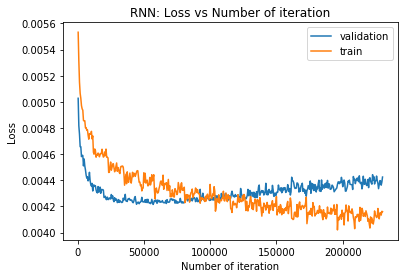

In [58]:
# visualization loss 
plt.plot(iteration_list,loss_list,label='validation')
plt.plot(iteration_list,train_loss_list,label='train')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.title("RNN: Loss vs Number of iteration")
plt.show()

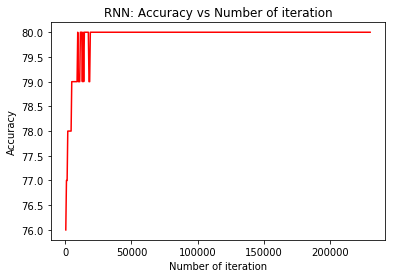

In [59]:
# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()

In [0]:
# torch.cuda.is_available()

In [0]:
# import pycuda.driver as cuda
# cuda.init()
# ## Get Id of default device
# torch.cuda.current_device()
# # 0
# cuda.Device(0).name() # '0' is the id of your GPU
# # Tesla K80

## Testing

In [62]:
test = pd.read_csv(files[1],index_col=0)
test.head()

,date,user,text
Id,,,
1280000,Tue Jun 16 18:18:12 PDT 2009,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1280001,Mon Apr 06 23:11:14 PDT 2009,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
1280002,Tue Jun 23 13:40:11 PDT 2009,sammydearr,@TiannaChaos i know just family drama. its la...
1280003,Mon Jun 01 10:26:07 PDT 2009,Lamb_Leanne,School email won't open and I have geography ...
1280004,Sat Jun 20 12:56:51 PDT 2009,yogicerdito,upper airways problem


In [0]:
textlist = test['text'].apply(simple_toks).tolist()

In [0]:
nums = [[stoi[w] if w in itos else 0 for w in sent] for sent in textlist]

In [0]:
with open("test_nums.txt", "wb") as fp:   #Pickling
    pickle.dump(nums, fp)

In [0]:
padded = pad_sequences(nums, maxlen=max_length, padding='post', truncating='post', value=0)

In [0]:
x = torch.from_numpy(padded).type(torch.LongTensor).to(device)
x = torch.utils.data.TensorDataset(x)
x_loader = torch.utils.data.DataLoader(x, batch_size = batch_size, shuffle = True)

In [67]:
preds = torch.zeros([len(test),1])
preds.shape

torch.Size([320000, 1])

In [0]:
model.eval()
cnt=0
for txt in x_loader:
    bs=txt[0].shape[0]
    txt = Variable(txt[0].reshape(-1,bs))
    outputs = model(txt)
    ncnt=cnt+bs
    preds[cnt:ncnt]=(outputs.data>=0.5)
    cnt=ncnt

In [0]:
out = pd.Series(preds.numpy().reshape(-1))

In [0]:
out.index=test.index

In [0]:
out = out.astype(int)

In [72]:
outdf = pd.DataFrame(out*4)
outdf.head(10)

,0
Id,
1280000,4
1280001,4
1280002,0
1280003,4
1280004,4
1280005,4
1280006,0
1280007,4
1280008,4


In [0]:
outdf.columns=['target']

In [74]:
outdf.head(10)

,target
Id,
1280000,4
1280001,4
1280002,0
1280003,4
1280004,4
1280005,4
1280006,0
1280007,4
1280008,4


In [0]:
outdf.to_csv('test_output.csv')

In [0]:
ts = pd.read_csv('test_output.csv')

In [77]:
ts.head()

,Id,target
0,1280000,4
1,1280001,4
2,1280002,0
3,1280003,4
4,1280004,4


## Required Printing

In [78]:
outdf

,target
Id,
1280000,4
1280001,4
1280002,0
1280003,4
1280004,4
1280005,4
1280006,0
1280007,4
1280008,4


In [79]:
print('training loss {}, validation loss {}, validation accuracy {}'.format(train_loss_list[-1],loss_list[-1],accuracy_list[-1]))

training loss 0.004160125739872456, validation loss 0.004424958489835262, validation accuracy 80
